In [1]:
#%% Imports
import os
import shutil
import nibabel as nib
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from nilearn.image import resample_to_img, resample_img
from nilearn.masking import compute_background_mask, compute_epi_mask
from nilearn.plotting import plot_roi, plot_epi
from scipy.spatial.distance import directed_hausdorff
from nipype.algorithms.metrics import Distance
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from scipy import interp
from itertools import chain
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening
from skimage.morphology import cube, octahedron, ball

In [2]:
def get_metrics(original_path, predicted_path, mask_path, th=None):
    original_data = nib.load(original_path).get_data()
    predicted_data = nib.load(predicted_path).get_data()
    mask_data = nib.load(mask_path).get_data() # use mask to limit results to the brain
    
    # Threshold data if necessary
    if th is not None:
        predicted_data = (predicted_data > th).astype(int)
    
    metrics = {}
    
    # Real positive cases
    metrics['P'] = float(np.sum((original_data == 1).astype(int) * mask_data))

    # Real negative cases
    metrics['N'] = float(np.sum((original_data == 0).astype(int) * mask_data))

    # True positive
    metrics['TP'] = float(np.sum((((predicted_data == 1).astype(int) +
                                   (original_data == 1).astype(int)) * mask_data) == 2))

    # True negative
    metrics['TN'] = float(np.sum((((predicted_data == 0).astype(int) +
                                   (original_data == 0).astype(int)) * mask_data) == 2))

    # False positive (all 1's in predicted minus original 1's)
    metrics['FP'] = float(np.sum((((predicted_data == 1).astype(int) -
                                   (original_data == 1).astype(int)) * mask_data) == 1))

    # False negative
    metrics['FN'] = float(np.sum((((predicted_data == 1).astype(int) -
                                   (original_data == 1).astype(int)) * mask_data) == -1))

    # True positive rate (Sensitivity, Recall)
    metrics['TPR'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])  

    # True negative rate (Specificity)
    metrics['TNR'] = metrics['TN'] / (metrics['TN'] + metrics['FP'])

    # Positive predictive value (Precision)
    metrics['PPV'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])

    # Negative predictive value
    metrics['NPV'] = metrics['TN'] / (metrics['TN'] + metrics['FN'])

    # False negative rate (Miss rate)
    metrics['FNR'] = 1 -  metrics['TPR']

    # False positive rate (Fall-out)
    metrics['FPR'] = 1 - metrics['TNR']

    # False discovery rate
    metrics['FDR'] = 1 - metrics['PPV']

    # False omission rate
    metrics['FOR'] = 1 - metrics['NPV']

    # Accuracy
    metrics['ACC'] = (metrics['TP'] + metrics['TN']) / \
                                (metrics['TP'] + 
                                 metrics['TN'] + 
                                 metrics['FP'] + 
                                 metrics['FN'])

    # F1 Score (also known as DSC, Sørensen–Dice coefficient, ...)
    #metrics['F1S'] = 2 * (metrics['PPV'] * metrics['TPR']) / \
    #                                (metrics['PPV'] + metrics['TPR'])
    metrics['F1S'] = (2*metrics['TP']) / (2*metrics['TP'] + metrics['FP'] + metrics['FN'])

    # Matthews correlation coefficient
    # The MCC can be more appropriate when negatives actually mean something,
    # and can be more useful in other ways.
    metrics['MCC'] = ((metrics['TP'] * metrics['TN']) - (metrics['FP'] * metrics['FN'])) / \
                        np.sqrt(
                            (metrics['TP'] + metrics['FP']) *
                            (metrics['TP'] + metrics['FN']) *
                            (metrics['TN'] + metrics['FP']) *
                            (metrics['TN'] + metrics['FN']))

    # Compute Hausdorff distance
    D = Distance()
    if th is not None:
        try:
            metrics['HD'] = D._eucl_max(nib.load(original_path),
                                        nib.Nifti1Image(predicted_data, nib.load(predicted_path).affine))
        except:
            metrics['HD'] = float('nan')
    else:
        metrics['HD'] = D._eucl_max(nib.load(original_path), nib.load(predicted_path))

    # Compute Jaccard index
    metrics['JI'] = metrics['TP'] / (metrics['FN'] + metrics['FP'] + metrics['TP'])

    # Informedness or Bookmaker informedness
    metrics['BM'] = metrics['TPR'] + metrics['TNR'] - 1

    #Markedness
    metrics['MK'] = metrics['PPV'] + metrics['NPV'] - 1

    
    return(metrics)
    

In [3]:
# Set working directory
os.chdir('/home/uziel/DISS')
# Set root of models to be post-processed
root = "./milestones_6"
model_variant = 'DM_V0_[0-4]' # choose model variant. Eg. "DM_V0_[0-4]".
tmp = model_variant.split('_')
if len(tmp) == 3:
    model_name = tmp[1]
elif len(tmp) == 4:
    model_name = tmp[1] + '_' + tmp[2]
else:
    model_name = tmp[1] + '_' + tmp[2] + '_' + tmp[3]
    
# Load all trained models (k-folds) of model_variant
trained_models = sorted(glob(os.path.join(root, model_variant)))

**POSTPROCESSING** for test cases

Upsample predicted labels and compute test metrics

In [4]:
##################################################################
##### POSTPROCESSING FOR K-FOLD CROSS-VALIDATION MODELS (0) ######
##################################################################

root_data = './data/ISLES2017/training'
root_data_processed = './data_processed/ISLES2017/training'
test_results = {}

for model in trained_models:
    root_1 = os.path.join(model, 'output/predictions/testSession/predictions')
    root_2 = os.path.dirname(root_1)
    
    # Load label predictions
    preds = sorted(glob(os.path.join(root_1, '*Segm.nii.gz')))
    # Load probability maps of background
    pmap_0 = sorted(glob(os.path.join(root_1, '*ProbMapClass0.nii.gz')))
    # Load probability maps of foreground
    pmap_1 = sorted(glob(os.path.join(root_1, '*ProbMapClass1.nii.gz')))
    
    test_results[os.path.basename(model)] = []
    
    # resize its prediction for final result validation
    for i in range(len(preds)):
        # Find subject that contains the code in pred.
        subject = sorted([y
                          for x in os.walk(root_data)
                          for y in glob(os.path.join(x[0], '*'))
                          if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                         ])[0].split('/')[-2]

        subject_channels = sorted([y
                                   for x in os.walk(os.path.join(root_data, subject))
                                   for y in glob(os.path.join(x[0], '*MR_*.nii'))
                                   if '4DPWI' not in y
                                  ])
        
        subject_label = sorted([y
                                for x in os.walk(os.path.join(root_data, subject))
                                for y in glob(os.path.join(x[0], '*OT*.nii'))
                               ])[0]

        subject_processed = sorted([y
                                    for x in os.walk(root_data_processed)
                                    for y in glob(os.path.join(x[0], '*'))
                                    if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                                   ])[0].split('/')[-2]
        
        subject_mask = sorted([y
                               for x in os.walk(os.path.join(root_data_processed, subject_processed))
                               for y in glob(os.path.join(x[0], '*mask*'))
                              ])[0]
        
        # Load ADC channel as reference
        original_img = nib.load(subject_channels[0])

        # Load predictions and prob maps
        pred_img = nib.load(preds[i])
        pmap_0_img = nib.load(pmap_0[i])
        pmap_1_img = nib.load(pmap_1[i])
        
        # Upsample to original size
        pred_img = resample_img(pred_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        pmap_0_img = resample_img(pmap_0_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        pmap_1_img = resample_img(pmap_1_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        # Load subject mask
        mask_img = nib.load(subject_mask)
        
        # Upsample to original size
        mask_img = resample_img(mask_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        # Save prediction
        pred_path = os.path.join(root_2, "_".join(os.path.basename(preds[i]).split('_')[:-1]) + '.pred.nii')
        pmap_0_path = os.path.join(root_2, "_".join(os.path.basename(pmap_0[i]).split('_')[:-1]) + '.pmap_0.nii')
        pmap_1_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.pmap_1.nii')
        mask_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.mask.nii')
        
        nib.save(pred_img, pred_path)
        nib.save(pmap_0_img, pmap_0_path)
        nib.save(pmap_1_img, pmap_1_path)
        nib.save(mask_img, mask_path)
        
        # Compute metrics between original and predicted label
        metrics = get_metrics(subject_label, pred_path, mask_path)
        
        test_results[os.path.basename(model)].append([subject,
                                                 subject_channels,
                                                 subject_label,
                                                 pred_path,
                                                 pmap_0_path,
                                                 pmap_1_path,
                                                 mask_path,
                                                 metrics])
        
    # Save model results
    with open(os.path.join(model, 'test_results.pkl'), 'wb') as output:
        pickle.dump(test_results[os.path.basename(model)], output, pickle.HIGHEST_PROTOCOL)
        
    # Compute mean and std of model subjects predictions' metrics
    metrics = np.array(test_results[os.path.basename(model)])[:,7]
    test_metrics = {}
    test_metrics['mean'] = {k : np.mean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics['std'] = {k : np.std([t[k] for t in metrics]) for k in metrics[0]}
    
    # Save each model's metrics
    with open(os.path.join(model, 'test_metrics.pkl'), 'wb') as output:
        pickle.dump(test_metrics, output, pickle.HIGHEST_PROTOCOL)

# Save all models' results
with open(os.path.join(root, model_name + '_test_results.pkl'), 'wb') as output:
    pickle.dump(test_results, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics, compute mean and std. This is the final result of an experiment, and determines its performance.

In [5]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics['mean'] = {k : np.mean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics['std'] = {k : np.std([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics
with open(os.path.join(root, model_name + '_test_metrics.pkl'), 'wb') as output:
    pickle.dump(test_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot original and predicted labels for test cases

/home/uziel/anaconda2/envs/diss/lib/python2.7/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/uziel/anaconda2/envs/diss/lib/python2.7/site-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


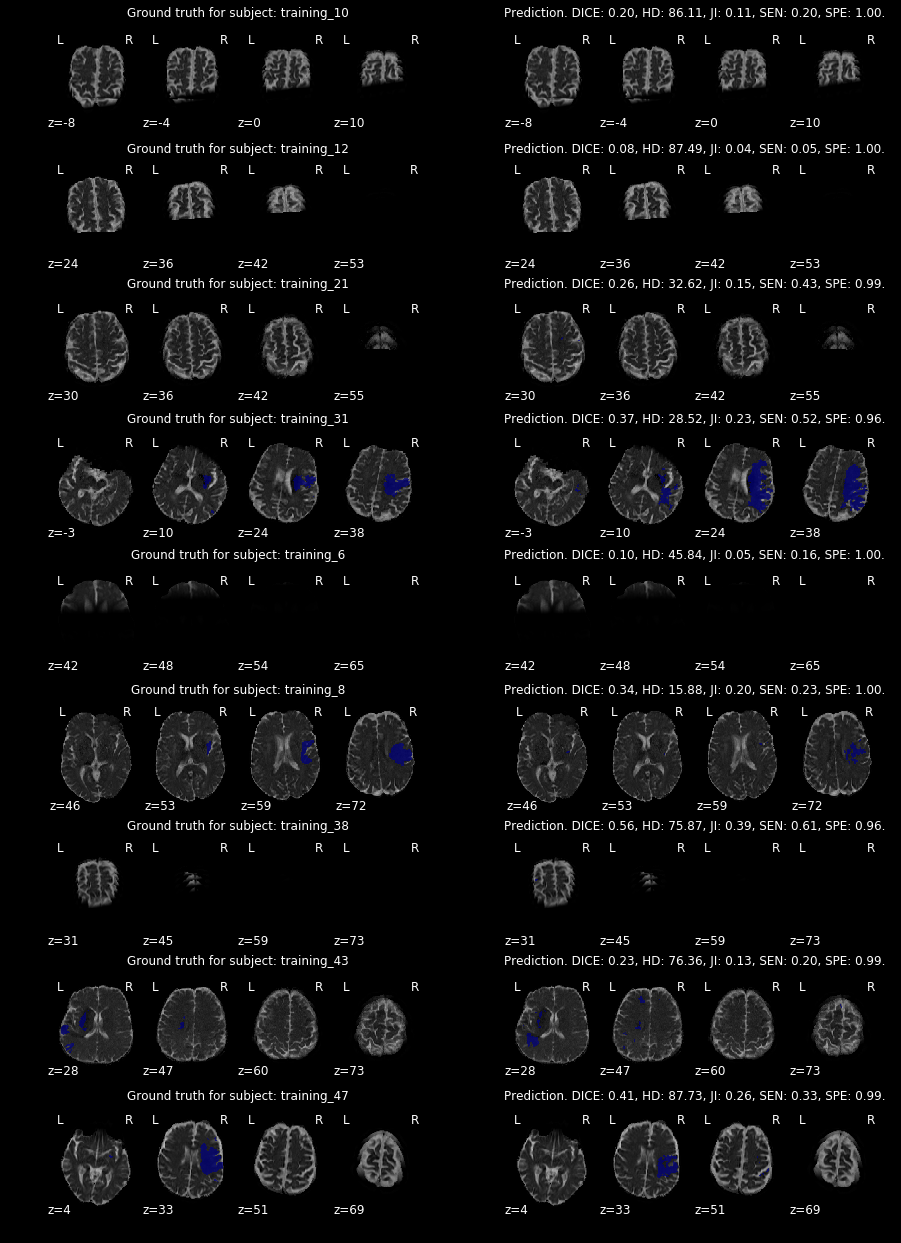

In [6]:
# Plot original label and predicted label on top of original image
for model in trained_models:
    
    plt.close('all')
    fig = plt.figure(figsize=(15, int(len(test_results[os.path.basename(model)])*2.5)))
    i = 1

    for subject, subject_channels, subject_label, pred_label, _, _, _, metrics in test_results[os.path.basename(model)]:
        original_img = nib.load(subject_channels[0])
        original_label_img = nib.load(subject_label)
        predicted_label_img = nib.load(pred_label)
        
        ax = fig.add_subplot(len(test_results[os.path.basename(model)]), 2, i)
        ax.set_title('Ground truth for subject: ' + subject,
                    color='w')
        temp = plot_roi(original_label_img, original_img, display_mode='z', cut_coords=4, figure=fig, axes=ax)
        ax = fig.add_subplot(len(test_results[os.path.basename(model)]), 2, i+1)
        ax.set_title('Prediction. DICE: %.2f, HD: %.2f, JI: %.2f, SEN: %.2f, SPE: %.2f.'
                             % (metrics['F1S'], metrics['HD'], metrics['JI'], metrics['TPR'], metrics['TNR']),
                    color='w')
        plot_roi(predicted_label_img, original_img, display_mode='z', cut_coords=temp.cut_coords, figure=fig, axes=ax)
        i += 2

    fig.patch.set_facecolor('xkcd:black')
    fig.savefig(os.path.join(model, 'testSegResults_' + os.path.basename(model) + '.pdf'),
                bbox_inches='tight',
                facecolor=fig.get_facecolor())

**ROC CURVE** for test cases

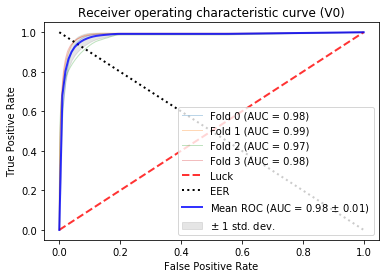

In [7]:
model_mean_fpr = {}
model_mean_tpr = {}
model_mean_auc = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in test_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    model_mean_fpr[os.path.basename(model)] = fpr
    model_mean_tpr[os.path.basename(model)] = tpr
    model_mean_auc[os.path.basename(model)] = auc(fpr, tpr)
    
plt.figure()
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for model in trained_models:
    tprs.append(interp(mean_fpr, model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)]))
    aucs.append(model_mean_auc[os.path.basename(model)])
    plt.plot(model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)], lw=1, alpha=0.3,
             label = 'Fold {0} (AUC = {1:0.2f})'
             ''.format(os.path.basename(model).split('_')[-1], model_mean_auc[os.path.basename(model)]))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.plot([0, 1], [1, 0], 'k:', lw=lw, label = 'EER')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve (' + model_name + ')')
plt.legend(loc='lower right')
plt.savefig(os.path.join(root, model_name + '_test_roc.pdf'), bbox_inches='tight')

**PRECISION-RECALL CURVE** for test cases

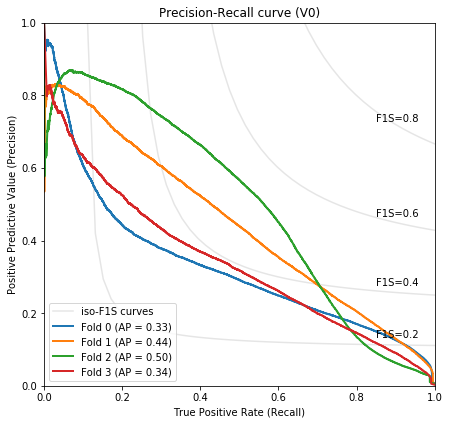

In [8]:
model_mean_precision = {}
model_mean_recall = {}
model_mean_ap = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in test_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    model_mean_precision[os.path.basename(model)] = precision
    model_mean_recall[os.path.basename(model)] = recall
    model_mean_ap[os.path.basename(model)] = average_precision

plt.figure(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1S={0:0.1f}'.format(f_score), xy=(0.85, y[45] + 0.02))
    
lines.append(l)
labels.append('iso-F1S curves')
lw = 2
for model in trained_models:
    l, = plt.plot(model_mean_recall[os.path.basename(model)],
                  model_mean_precision[os.path.basename(model)],
                  lw=lw)
    lines.append(l)
    labels.append('Fold {0} (AP = {1:0.2f})'
                  ''.format(os.path.basename(model).split('_')[-1],
                            model_mean_ap[os.path.basename(model)]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('True Positive Rate (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Precision-Recall curve (' + model_name + ')')
plt.legend(lines, labels, loc='lower left')
plt.savefig(os.path.join(root, model_name + '_test_pr.pdf'), bbox_inches='tight')

**POSTPROCESSING** for validation cases

Upsample predicted labels and compute validation metrics

In [9]:
##################################################################
##### POSTPROCESSING FOR K-FOLD CROSS-VALIDATION MODELS (0) ######
##################################################################

root_data = './data/ISLES2017/training'
root_data_processed = './data_processed/ISLES2017/training'
val_results = {}

for model in trained_models:
    root_1 = os.path.join(model, 'output/predictions/valSession/predictions')
    root_2 = os.path.dirname(root_1)
    
    # Load label predictions
    preds = sorted(glob(os.path.join(root_1, '*Segm.nii.gz')))
    # Load probability maps of background
    pmap_0 = sorted(glob(os.path.join(root_1, '*ProbMapClass0.nii.gz')))
    # Load probability maps of foreground
    pmap_1 = sorted(glob(os.path.join(root_1, '*ProbMapClass1.nii.gz')))
    
    val_results[os.path.basename(model)] = []
    
    # resize its prediction for final result validation
    for i in range(len(preds)):
        # Find subject that contains the code in pred.
        subject = sorted([y
                          for x in os.walk(root_data)
                          for y in glob(os.path.join(x[0], '*'))
                          if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                         ])[0].split('/')[-2]

        subject_channels = sorted([y
                                   for x in os.walk(os.path.join(root_data, subject))
                                   for y in glob(os.path.join(x[0], '*MR_*.nii'))
                                   if '4DPWI' not in y
                                  ])
        
        subject_label = sorted([y
                                for x in os.walk(os.path.join(root_data, subject))
                                for y in glob(os.path.join(x[0], '*OT*.nii'))
                               ])[0]

        subject_processed = sorted([y
                                    for x in os.walk(root_data_processed)
                                    for y in glob(os.path.join(x[0], '*'))
                                    if os.path.basename(preds[i]).split('_')[-2].split('.')[-1] in y
                                   ])[0].split('/')[-2]
        
        subject_mask = sorted([y
                               for x in os.walk(os.path.join(root_data_processed, subject_processed))
                               for y in glob(os.path.join(x[0], '*mask*'))
                              ])[0]
        
        # Load ADC channel as reference
        original_img = nib.load(subject_channels[0])

        # Load predictions and prob maps
        pred_img = nib.load(preds[i])
        pmap_0_img = nib.load(pmap_0[i])
        pmap_1_img = nib.load(pmap_1[i])
        
        # Upsample to original size
        pred_img = resample_img(pred_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        pmap_0_img = resample_img(pmap_0_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        pmap_1_img = resample_img(pmap_1_img,
                                  original_img.affine,
                                  original_img.shape,
                                  interpolation='continuous')
        
        # Load subject mask
        mask_img = nib.load(subject_mask)
        
        # Upsample to original size
        mask_img = resample_img(mask_img,
                                original_img.affine,
                                original_img.shape,
                                interpolation='nearest')
        
        # Save prediction
        pred_path = os.path.join(root_2, "_".join(os.path.basename(preds[i]).split('_')[:-1]) + '.pred.nii')
        pmap_0_path = os.path.join(root_2, "_".join(os.path.basename(pmap_0[i]).split('_')[:-1]) + '.pmap_0.nii')
        pmap_1_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.pmap_1.nii')
        mask_path = os.path.join(root_2, "_".join(os.path.basename(pmap_1[i]).split('_')[:-1]) + '.mask.nii')
        
        nib.save(pred_img, pred_path)
        nib.save(pmap_0_img, pmap_0_path)
        nib.save(pmap_1_img, pmap_1_path)
        nib.save(mask_img, mask_path)
        
        # Compute metrics between original and predicted label
        metrics = get_metrics(subject_label, pred_path, mask_path)
        
        val_results[os.path.basename(model)].append([subject,
                                                 subject_channels,
                                                 subject_label,
                                                 pred_path,
                                                 pmap_0_path,
                                                 pmap_1_path,
                                                 mask_path,
                                                 metrics])
        
    # Save model results
    with open(os.path.join(model, 'val_results.pkl'), 'wb') as output:
        pickle.dump(val_results[os.path.basename(model)], output, pickle.HIGHEST_PROTOCOL)
        
    # Compute mean and std of model subjects predictions' metrics
    metrics = np.array(val_results[os.path.basename(model)])[:,7]
    val_metrics = {}
    val_metrics['mean'] = {k : np.mean([t[k] for t in metrics]) for k in metrics[0]}
    val_metrics['std'] = {k : np.std([t[k] for t in metrics]) for k in metrics[0]}
    
    # Save each model's metrics
    with open(os.path.join(model, 'val_metrics.pkl'), 'wb') as output:
        pickle.dump(val_metrics, output, pickle.HIGHEST_PROTOCOL)

# Save all models' results
with open(os.path.join(root, model_name + '_val_results.pkl'), 'wb') as output:
    pickle.dump(val_results, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics, compute mean and std

In [10]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'val_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
val_metrics['mean'] = {k : np.mean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
val_metrics['std'] = {k : np.std([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics
with open(os.path.join(root, model_name + '_val_metrics.pkl'), 'wb') as output:
    pickle.dump(val_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot original and predicted labels for validation cases

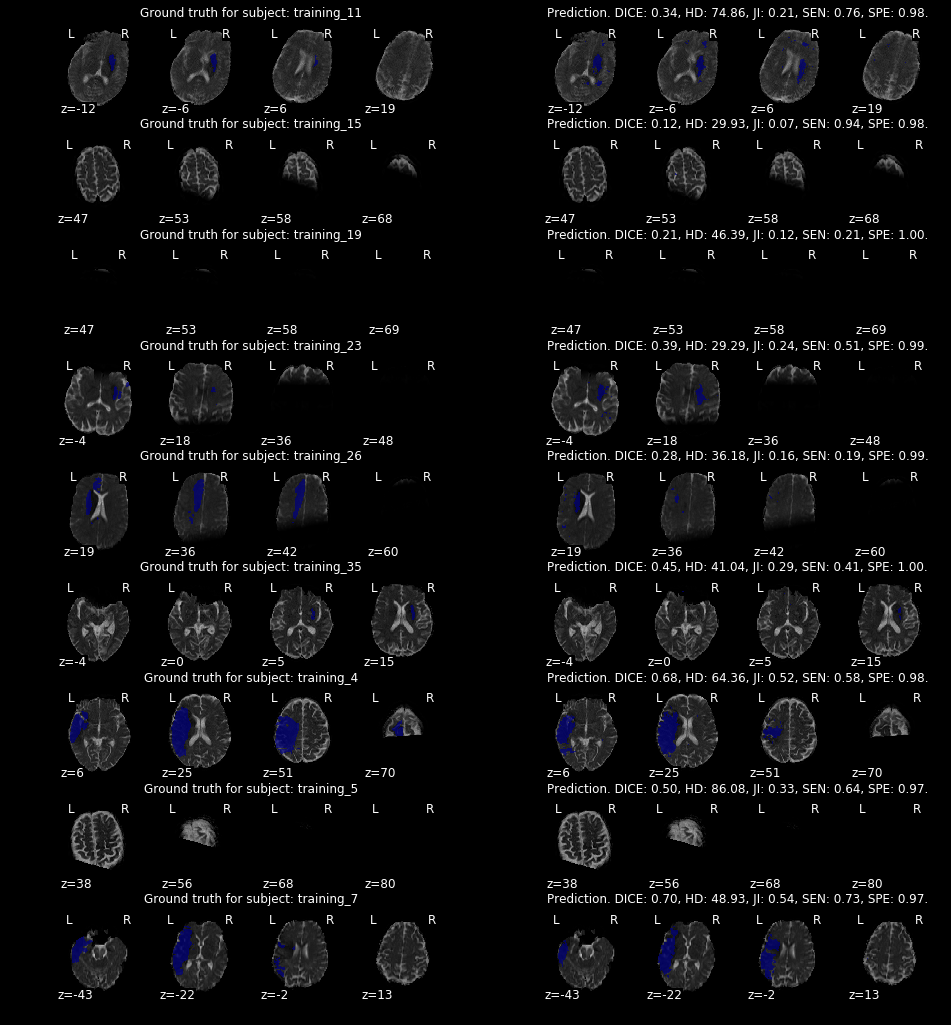

In [11]:
# Plot original label and predicted label on top of original image
for model in trained_models:
    
    plt.close('all')
    fig = plt.figure(figsize=(16, len(val_results[os.path.basename(model)])*2))
    i = 1

    for subject, subject_channels, subject_label, pred_label, _, _, _, metrics in val_results[os.path.basename(model)]:
        original_img = nib.load(subject_channels[0])
        original_label_img = nib.load(subject_label)
        predicted_label_img = nib.load(pred_label)
        
        ax = fig.add_subplot(len(val_results[os.path.basename(model)]), 2, i)
        ax.set_title('Ground truth for subject: ' + subject,
                    color='w')
        temp = plot_roi(original_label_img, original_img, display_mode='z', cut_coords=4, figure=fig, axes=ax)
        ax = fig.add_subplot(len(val_results[os.path.basename(model)]), 2, i+1)
        ax.set_title('Prediction. DICE: %.2f, HD: %.2f, JI: %.2f, SEN: %.2f, SPE: %.2f.'
                             % (metrics['F1S'], metrics['HD'], metrics['JI'], metrics['TPR'], metrics['TNR']),
                    color='w')
        plot_roi(predicted_label_img, original_img, display_mode='z', cut_coords=temp.cut_coords, figure=fig, axes=ax)
        i += 2

    fig.patch.set_facecolor('xkcd:black')
    fig.savefig(os.path.join(model, 'valSegResults_' + os.path.basename(model) + '.pdf'),
                bbox_inches='tight',
                facecolor=fig.get_facecolor())

**ROC CURVE** for validation cases

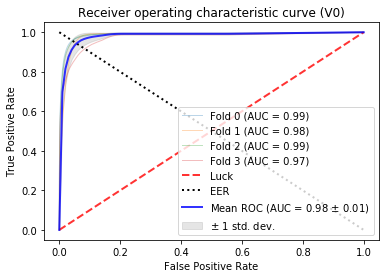

In [12]:
model_mean_fpr = {}
model_mean_tpr = {}
model_mean_auc = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    model_mean_fpr[os.path.basename(model)] = fpr
    model_mean_tpr[os.path.basename(model)] = tpr
    model_mean_auc[os.path.basename(model)] = auc(fpr, tpr)
    
plt.figure()
lw = 2
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for model in trained_models:
    tprs.append(interp(mean_fpr, model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)]))
    aucs.append(model_mean_auc[os.path.basename(model)])
    plt.plot(model_mean_fpr[os.path.basename(model)], model_mean_tpr[os.path.basename(model)], lw=1, alpha=0.3,
             label = 'Fold {0} (AUC = {1:0.2f})'
             ''.format(os.path.basename(model).split('_')[-1], model_mean_auc[os.path.basename(model)]))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.plot([0, 1], [1, 0], 'k:', lw=lw, label = 'EER')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve (' + model_name + ')')
plt.legend(loc='lower right')
plt.savefig(os.path.join(root, model_name + '_val_roc.pdf'), bbox_inches='tight')

**PRECISION-RECALL CURVE** for validation cases

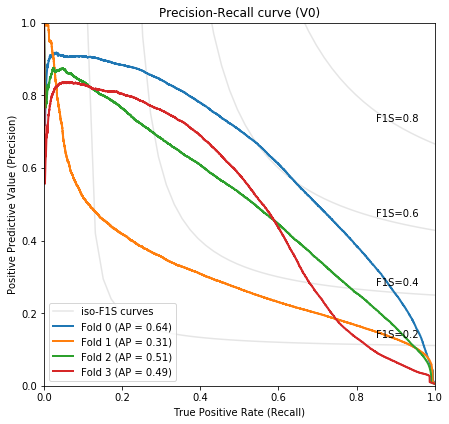

In [13]:
model_mean_precision = {}
model_mean_recall = {}
model_mean_ap = {}
for model in trained_models:
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, _, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    
    model_mean_precision[os.path.basename(model)] = precision
    model_mean_recall[os.path.basename(model)] = recall
    model_mean_ap[os.path.basename(model)] = average_precision

plt.figure(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F1S={0:0.1f}'.format(f_score), xy=(0.85, y[45] + 0.02))
    
lines.append(l)
labels.append('iso-F1S curves')
lw = 2
for model in trained_models:
    l, = plt.plot(model_mean_recall[os.path.basename(model)],
                  model_mean_precision[os.path.basename(model)],
                  lw=lw)
    lines.append(l)
    labels.append('Fold {0} (AP = {1:0.2f})'
                  ''.format(os.path.basename(model).split('_')[-1],
                            model_mean_ap[os.path.basename(model)]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('True Positive Rate (Recall)')
plt.ylabel('Positive Predictive Value (Precision)')
plt.title('Precision-Recall curve (' + model_name + ')')
plt.legend(lines, labels, loc='lower left')
plt.savefig(os.path.join(root, model_name + '_val_pr.pdf'), bbox_inches='tight')

**THRESHOLD TUNING V0**

Use precision-recall curve on validation cases to maximize F1S on test cases.

In [14]:
all_test_metrics_tht_v0 = {}
for model in trained_models:
    # Compute best average threshold for validation cases
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Optimal threshold is where precision * recall is maximum
    tmp = precision * recall        
    # The closest point is the furthest from bottom-left corner
    idx = np.argwhere(tmp == np.max(tmp))
    th_op = thresholds[idx]
    
    all_test_metrics_tht_v0[os.path.basename(model)] = []
    # Recompute test metrics with optimal threshold from validation cases
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in test_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        
        # Compute new metrics after new threshold
        metrics = get_metrics(subject_label, pmap_1_path, mask_path, th_op)
        metrics['TH_OP'] = th_op
        all_test_metrics_tht_v0[os.path.basename(model)].append(metrics)
        
    metrics = np.array(all_test_metrics_tht_v0[os.path.basename(model)])
    test_metrics_tht_v0 = {}
    test_metrics_tht_v0['mean'] = {k : np.nanmean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics_tht_v0['std'] = {k : np.nanstd([t[k] for t in metrics]) for k in metrics[0]}

    with open(os.path.join(model, 'test_metrics_tht_v0.pkl'), 'wb') as output:
        pickle.dump(test_metrics_tht_v0, output, pickle.HIGHEST_PROTOCOL)

# Save all metrics after threshold tuning v0 for future reference
with open(os.path.join(root, model_name +  '_test_results_tht_v0.pkl'), 'wb') as output:
    pickle.dump(all_test_metrics_tht_v0, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics after **threshold tuning v0**, compute mean and std.

In [15]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics_tht_v0.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics_tht_v0['mean'] = {k : np.nanmean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics_tht_v0['std'] = {k : np.nanstd([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics after tht_v0
with open(os.path.join(root, model_name + '_test_metrics_tht_v0.pkl'), 'wb') as output:
    pickle.dump(test_metrics_tht_v0, output, pickle.HIGHEST_PROTOCOL)

**THRESHOLD TUNING V1**

Use ROC curve on validation cases to maximize BM on test cases.

In [16]:
all_test_metrics_tht_v1 = {}
for model in trained_models:
    # Compute best average threshold for validation cases
    original_data = []
    predicted_data = []
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in val_results[os.path.basename(model)]:
        original_data.append(nib.load(subject_label).get_data().ravel())
        predicted_data.append(nib.load(pmap_1_path).get_data().ravel())

    # Join all subjects to perform micro-average
    y_true = list(chain.from_iterable(original_data))
    y_pred = list(chain.from_iterable(predicted_data))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # Optimal threshold is where tpr - fpr is maximum
    d = tpr - fpr
    idx = np.argwhere(d == np.max(d))
    th_op = thresholds[idx]
    
    all_test_metrics_tht_v1[os.path.basename(model)] = []
    # Recompute test metrics with optimal threshold from validation cases
    for _, _, subject_label, _, _, pmap_1_path, mask_path, _ in test_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        
        # Compute new metrics after new threshold
        metrics = get_metrics(subject_label, pmap_1_path, mask_path, th_op)
        metrics['TH_OP'] = th_op
        all_test_metrics_tht_v1[os.path.basename(model)].append(metrics)
        
    metrics = np.array(all_test_metrics_tht_v1[os.path.basename(model)])
    test_metrics_tht_v1 = {}
    test_metrics_tht_v1['mean'] = {k : np.nanmean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics_tht_v1['std'] = {k : np.nanstd([t[k] for t in metrics]) for k in metrics[0]}

    with open(os.path.join(model, 'test_metrics_tht_v1.pkl'), 'wb') as output:
        pickle.dump(test_metrics_tht_v1, output, pickle.HIGHEST_PROTOCOL)

# Save all metrics after threshold tuining for future reference
with open(os.path.join(root, model_name +  '_test_results_tht_v1.pkl'), 'wb') as output:
    pickle.dump(all_test_metrics_tht_v1, output, pickle.HIGHEST_PROTOCOL)

Load each model's metrics after **threshold tuning v1**, compute mean and std.

In [17]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics_tht_v1.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics_tht_v1['mean'] = {k : np.nanmean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics_tht_v1['std'] = {k : np.nanstd([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics after tht_v1
with open(os.path.join(root, model_name + '_test_metrics_tht_v1.pkl'), 'wb') as output:
    pickle.dump(test_metrics_tht_v1, output, pickle.HIGHEST_PROTOCOL)

**FILL HOLES**

Apply morphological operation of closing to fill holes in the predicted label (predicted segmentation)

In [18]:
# Define struct
#struct = ndimage.generate_binary_structure(3, 3)
struct = ball(3)
all_test_metrics_de = {}
for model in trained_models:
    all_test_metrics_de[os.path.basename(model)] = []
    with open(os.path.join(model, 'test_metrics_tht_v0.pkl'), 'rb') as input:
        metrics = pickle.load(input)
        th = metrics['mean']['TH_OP']
        
    iterations = []
    for _, _, subject_label, pred_label, _, pmap_1_path, mask_path, _ in val_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        predicted_label = nib.load(pred_label).get_data()
        
        scores = []
        for i in range(1,11):
            try:
                # Apply morphological operation of closing
                #cl_data = binary_closing(predicted_data > th, struct, iterations=i)
                cl_data = binary_closing(predicted_label, struct, iterations=i)
                # Compute F1S
                scores.append(f1_score(original_data.ravel(), cl_data.ravel()))
            except:
                break
        # Get number of iterations that achieved max F1S
        idx = np.argwhere(scores == np.max(scores))[0]
        iterations.append(idx+1)        
        
    mean_iter = int(np.floor(np.mean(iterations)))
    for _, _, subject_label, pred_label, _, pmap_1_path, mask_path, _ in test_results[os.path.basename(model)]:
        original_data = nib.load(subject_label).get_data()
        predicted_data = nib.load(pmap_1_path).get_data()
        predicted_label = nib.load(pred_label).get_data()
        
        # Apply morphological operation of closing
        #img = binary_closing(predicted_data > th, struct, iterations=mean_iter)
        img = binary_closing(predicted_label, struct, iterations=mean_iter)
        # Save image temporarly
        temp_path = 'temp.nii.gz'
        nib.save(nib.Nifti1Image(img.astype(int), nib.load(subject_label).affine), temp_path)
        
        # Recompute metrics
        metrics = get_metrics(subject_label, temp_path, mask_path, 0)
        metrics['TH_OP'] = th
        metrics['N_iter'] = mean_iter
        all_test_metrics_de[os.path.basename(model)].append(metrics)
        
    metrics = np.array(all_test_metrics_de[os.path.basename(model)])
    test_metrics_de = {}
    test_metrics_de['mean'] = {k : np.nanmean([t[k] for t in metrics]) for k in metrics[0]}
    test_metrics_de['std'] = {k : np.nanstd([t[k] for t in metrics]) for k in metrics[0]}

    with open(os.path.join(model, 'test_metrics_de.pkl'), 'wb') as output:
        pickle.dump(test_metrics_de, output, pickle.HIGHEST_PROTOCOL)

# Save all metrics after dilation-erosion for future reference
with open(os.path.join(root, model_name +  '_all_test_metrics_de.pkl'), 'wb') as output:
    pickle.dump(all_test_metrics_de, output, pickle.HIGHEST_PROTOCOL)

/home/uziel/anaconda2/envs/diss/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics_de.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

metrics = np.array(metrics)
test_metrics_de['mean'] = {k : np.nanmean([t['mean'][k] for t in metrics]) for k in metrics[0]['mean']}
test_metrics_de['std'] = {k : np.nanstd([t['std'][k] for t in metrics]) for k in metrics[0]['std']}

# Save final experiment metrics after tht_v1
with open(os.path.join(root, model_name + '_test_metrics_de.pkl'), 'wb') as output:
    pickle.dump(test_metrics_de, output, pickle.HIGHEST_PROTOCOL)

**PROCESS TRAINING AND VALIDATION RESULTS**

Plot and save training progress

In [20]:
for model in trained_models:
    # Plot and save training progress
    os.system("python ischleseg/deepmedic/plotSaveTrainingProgress.py " +
              os.path.join(model, "output/logs/trainSession.txt -d -m 20 -s"))
    # Move files to the corresponding model directory
    os.system("mv trainingProgress.pdf " + os.path.join(model, 'trainingProgress_' + os.path.basename(model) + '.pdf'))
    os.system("mv trainingProgress.pkl " + os.path.join(model, 'trainingProgress.pkl'))


Load training metrics and compute mean and variance between models (includes training and validation metrics)

In [21]:
# Load "measuredMetricsFromAllExperiments"
# 1st dimension: "Validation" (0), "Training" (1)
# 2nd dimension: ? (0)
# 3rd dimension: "Mean Accuracy" (0), "Sensitivity" (1), "Specificity" (2), "DSC (samples)" (3), "DSC (full-segm)" (4)

metrics = {}
for model in trained_models:
    with open(os.path.join(model, 'trainingProgress.pkl'), 'rb') as input:
        metrics[os.path.basename(model)] = np.array(pickle.load(input))
        metrics[os.path.basename(model)][0,0,4] = np.array(metrics[os.path.basename(model)][0,0,4])
        
# Compute mean and variance of all models' variations metrics
metrics_mean = {}
metrics_std = {}
metrics_values = np.array(metrics.values())
metrics_names_0 = ['Validation', 'Training']
metrics_names_1 = ['Mean Accuracy', 'Sensitivity', 'Specificity', 'DSC (Samples)', 'DSC (full-segm)']

for i in range(len(metrics_names_0)):
    metrics_mean[metrics_names_0[i]] = {}
    metrics_std[metrics_names_0[i]] = {}
    for j in range(len(metrics_names_1)):
        if i == 1 and j == 4: # Skip DSC_full for training (is never calculated)
            metrics_mean[metrics_names_0[i]][metrics_names_1[j]] = np.zeros(35*20)
            metrics_std[metrics_names_0[i]][metrics_names_1[j]] = np.zeros(35*20)
            continue 
        metrics_mean[metrics_names_0[i]][metrics_names_1[j]] = np.mean(metrics_values[:,i,0,j])
        metrics_std[metrics_names_0[i]][metrics_names_1[j]] = np.std(metrics_values[:,i,0,j])

train_val_metrics = {}
train_val_metrics['mean'] = metrics_mean
train_val_metrics['std'] = metrics_std
# Save final experiment progress metrics
with open(os.path.join(root, model_name + '_train_val_metrics.pkl'), 'wb') as output:
    pickle.dump(train_val_metrics, output, pickle.HIGHEST_PROTOCOL)

Plot mean training and validation progress metrics of all trained models

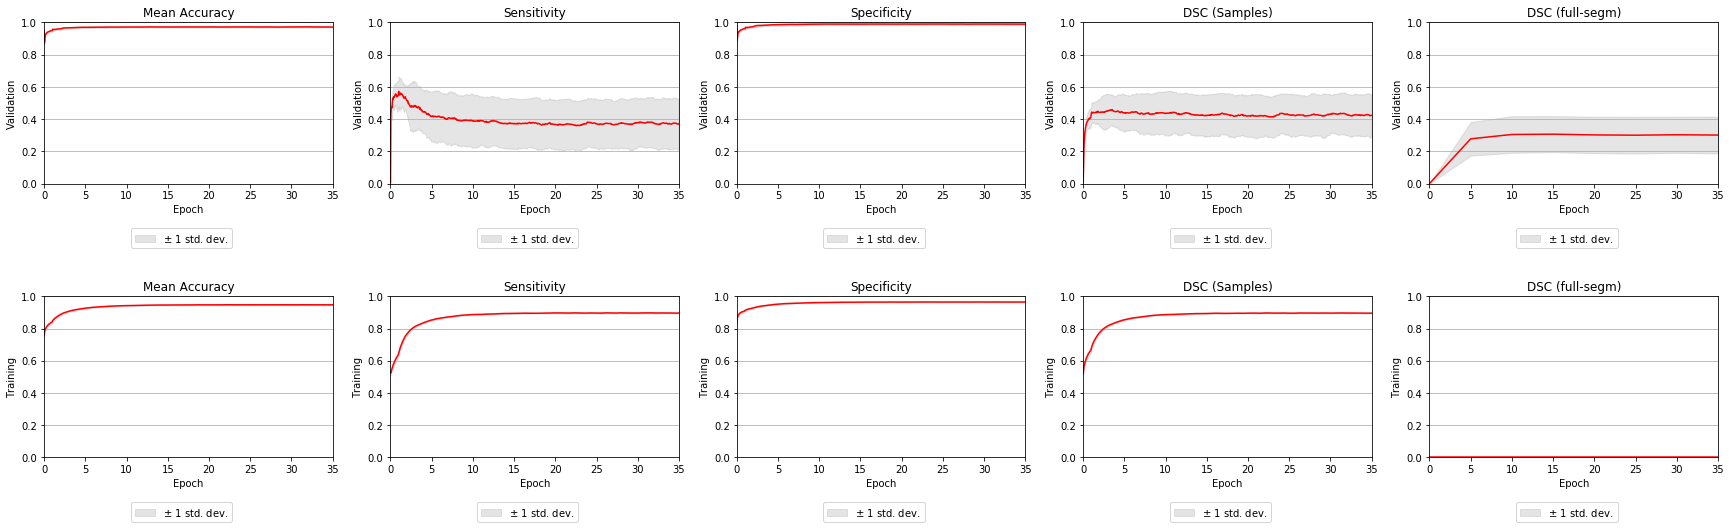

In [22]:
metrics = []
for model in trained_models:
    with open(os.path.join(model, 'test_metrics.pkl'), 'rb') as input:
        metrics.append(pickle.load(input))

plt.close('all')
rows, cols = [2, 5]
fig = plt.figure(figsize=(cols*6, rows*4))
for i in range(len(metrics_names_0)):
    for j in range(len(metrics_names_1)):
        ax = fig.add_subplot(rows, cols, i * cols + 1 + j)
        upper = np.minimum(metrics_mean[metrics_names_0[i]][metrics_names_1[j]] +
                           metrics_std[metrics_names_0[i]][metrics_names_1[j]], 1)
        lower = np.maximum(metrics_mean[metrics_names_0[i]][metrics_names_1[j]] -
                           metrics_std[metrics_names_0[i]][metrics_names_1[j]], 0)
        if i == 0 and j == 4:
            x = np.arange(0, 40, 5)
        else:
            x = np.arange(0, 35, 1/20.0)
        
        plt.plot(x, metrics_mean[metrics_names_0[i]][metrics_names_1[j]], 'r')        
        plt.fill_between(x, lower, upper,
                         color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
        plt.xlim(0, 35)
        plt.ylim(0, 1.0)
        plt.xlabel('Epoch')
        plt.ylabel(metrics_names_0[i])
        plt.title(metrics_names_1[j])
        plt.legend(loc=(0.3, -0.4))
        ax.yaxis.grid(True)

# Save mean training and validation metrics of all trained models averaged
plt.subplots_adjust(hspace=0.7)
plt.savefig(os.path.join(root, model_name + '_meanTrainValProgress.pdf'), bbox_inches='tight')

In [23]:
# V0 files
with open('/home/uziel/DISS/milestones_6/V0_test_metrics.pkl', 'rb') as input:
    test_metrics_V0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V0_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V0_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V0_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V0_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V0_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_de = pickle.load(input)

# V1 files
with open('/home/uziel/DISS/milestones_6/V1_test_metrics.pkl', 'rb') as input:
    test_metrics_V1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V1_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V1_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V1_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V1_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V1_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V1_de = pickle.load(input)

# V2 files
with open('/home/uziel/DISS/milestones_6/V2_test_metrics.pkl', 'rb') as input:
    test_metrics_V2 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V2_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V2_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V2_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V2_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_6/V2_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V2_de = pickle.load(input)

IOError: [Errno 2] No such file or directory: '/home/uziel/DISS/milestones_6/V2_test_metrics.pkl'

In [ ]:
# V0_R files
with open('/home/uziel/DISS/milestones_5/V0_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V0_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V0_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V0_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V0_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V0_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V0_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_R_de = pickle.load(input)
    
# V0_R_transfer files
with open('/home/uziel/DISS/milestones_5/V0_R_transfer_test_metrics.pkl', 'rb') as input:
    test_metrics_V0_R_transfer = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V0_R_transfer_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V0_R_transfer_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V0_R_transfer_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V0_R_transfer_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V0_R_transfer_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_R_transfer_de = pickle.load(input)
    
# V1_R files
with open('/home/uziel/DISS/milestones_5/V1_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V1_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V1_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V1_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V1_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V1_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V1_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_R_de = pickle.load(input)
    
# V1_R_transfer files
with open('/home/uziel/DISS/milestones_5/V1_R_transfer_test_metrics.pkl', 'rb') as input:
    test_metrics_V1_R_transfer = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V1_R_transfer_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V1_R_transfer_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V1_R_transfer_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V1_R_transfer_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V1_R_transfer_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_R_transfer_de = pickle.load(input)
    
# V2_R files
with open('/home/uziel/DISS/milestones_5/V2_R_test_metrics.pkl', 'rb') as input:
    test_metrics_V2_R = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V2_R_test_metrics_tht_v0.pkl', 'rb') as input:
    test_metrics_V2_R_tht_v0 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V2_R_test_metrics_tht_v1.pkl', 'rb') as input:
    test_metrics_V2_R_tht_v1 = pickle.load(input)
with open('/home/uziel/DISS/milestones_5/V2_R_test_metrics_de.pkl', 'rb') as input:
    test_metrics_V0_R_de = pickle.load(input)